In [ ]:
import pandas as pd
import numpy as np
import string
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm as tq

In [ ]:
books_df = pd.read_csv('gutenberg_books_partitions.csv')

In [ ]:
from keras.preprocessing.text import one_hot , Tokenizer
from keras.preprocessing.sequence import  pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, SpatialDropout1D , LSTM
from keras.layers import Dropout , MaxPooling1D , Flatten , Dense , Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## Data pre-processing
- Tokenization
- Vectorization
- Padding

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each partition.
MAX_SEQUENCE_LENGTH = 100

sentences = books_df.partition.values

# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14022 unique tokens.


In [ ]:
## Input sequences
X = tokenizer.texts_to_sequences(sentences)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of Input data tensor:', X.shape)

Shape of Input data tensor: (995, 100)


In [ ]:
## Labels 
Y = pd.get_dummies(books_df['book_name']).values
print('Shape of Label data tensor:', Y.shape)

Shape of Label data tensor: (995, 5)


In [ ]:
# ## Splitting dataset into test and train 
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Model Evaluation Utils

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix

In [ ]:
def plot_model_accuracies(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def plot_model_losses(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def classification_metrics(y_true, y_pred):
  print("\n\nClassification Report\n")
  print(classification_report(y_true, y_pred))  
  
  print("\n\nConfusion Matrix\n")
  # print(confusion_matrix(y_true, y_pred))
  sn.heatmap(confusion_matrix(y_true, y_pred) , annot=True)
  
  

## Model-1

- Basic Deep Learning Model using Embedding and Dense layers 

In [ ]:
# define the model
model = Sequential()
# model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Flatten())
model.add(Dense(10, activation='tanh'))
model.add(Dense(5, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                100010    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 1,100,065
Trainable params: 1,100,065
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 20
batch_size = 32

# # fit the model
# model.fit(padded_docs, labels, epochs=50, verbose=1)

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1)
# evaluate the model
loss, accuracy = model.evaluate(X, Y, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/20
28/28 [==============================] - 15s 35ms/step - loss: 1.5481 - accuracy: 0.3469 - val_loss: 1.4657 - val_accuracy: 0.0000e+00
Epoch 2/20
28/28 [==============================] - 0s 16ms/step - loss: 0.9862 - accuracy: 0.7575 - val_loss: 1.4652 - val_accuracy: 0.0000e+00
Epoch 3/20
28/28 [==============================] - 0s 17ms/step - loss: 0.5530 - accuracy: 0.8881 - val_loss: 1.2363 - val_accuracy: 0.2400
Epoch 4/20
28/28 [==============================] - 0s 16ms/step - loss: 0.3263 - accuracy: 0.9166 - val_loss: 1.0813 - val_accuracy: 0.4700
Epoch 5/20
28/28 [==============================] - 0s 17ms/step - loss: 0.1989 - accuracy: 0.9920 - val_loss: 0.8773 - val_accuracy: 0.6800
Epoch 6/20
28/28 [==============================] - 0s 17ms/step - loss: 0.1367 - accuracy: 1.0000 - val_loss: 0.7533 - val_accuracy: 0.8000
Epoch 7/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0972 - accuracy: 1.0000 - val_loss: 0.7194 - val_accuracy: 0.8100
Epoc

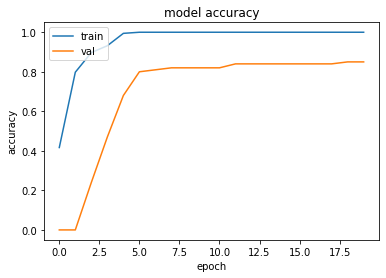

In [ ]:
plot_model_accuracies(history)

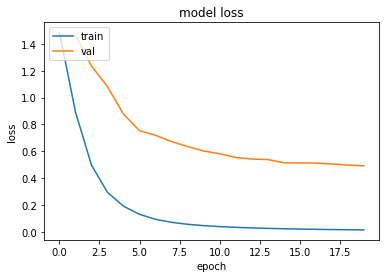

In [ ]:
plot_model_losses(history)



Classification Report

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       199
           1       1.00      1.00      1.00       199
           2       1.00      1.00      1.00       199
           3       0.99      1.00      1.00       199
           4       1.00      0.92      0.96       199

    accuracy                           0.98       995
   macro avg       0.99      0.98      0.98       995
weighted avg       0.99      0.98      0.98       995



Confusion Matrix



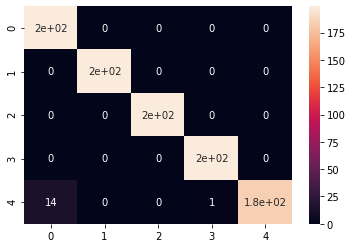

In [ ]:
predictions = model.predict(X)
classification_metrics(Y.argmax(axis=1), predictions.argmax(axis=1))

## Model-2

- Deep Learning Model using embedding layer and LSTM  

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 20
batch_size = 32

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
28/28 [==============================] - 20s 256ms/step - loss: 1.5969 - accuracy: 0.2778 - val_loss: 1.8320 - val_accuracy: 0.0000e+00
Epoch 2/20
28/28 [==============================] - 6s 213ms/step - loss: 1.3254 - accuracy: 0.5367 - val_loss: 1.7782 - val_accuracy: 0.0000e+00
Epoch 3/20
28/28 [==============================] - 6s 217ms/step - loss: 0.9802 - accuracy: 0.6540 - val_loss: 1.4867 - val_accuracy: 0.0400
Epoch 4/20
28/28 [==============================] - 6s 214ms/step - loss: 0.6663 - accuracy: 0.7963 - val_loss: 2.0099 - val_accuracy: 0.0500
Epoch 5/20
28/28 [==============================] - 6s 214ms/step - loss: 0.2841 - accuracy: 0.9268 - val_loss: 1.0781 - val_accuracy: 0.8200
Epoch 6/20
28/28 [==============================] - 6s 214ms/step - loss: 0.5496 - accuracy: 0.8094 - val_loss: 0.6037 - val_accuracy: 0.8600
Epoch 7/20
28/28 [==============================] - 6s 216ms/step - loss: 0.1584 - accuracy: 0.9779 - val_loss: 0.3349 - val_accuracy: 0.96

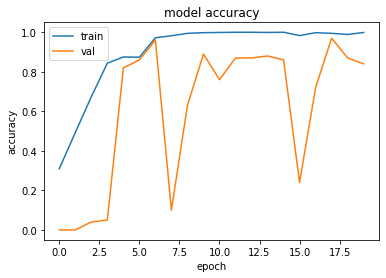

In [ ]:
plot_model_accuracies(history)

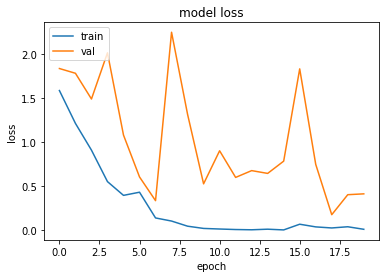

In [ ]:
plot_model_losses(history)



Classification Report

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       0.93      1.00      0.96       199
           2       1.00      1.00      1.00       199
           3       1.00      1.00      1.00       199
           4       1.00      0.92      0.96       199

    accuracy                           0.98       995
   macro avg       0.98      0.98      0.98       995
weighted avg       0.98      0.98      0.98       995



Confusion Matrix



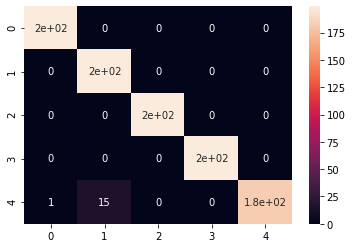

In [ ]:
predictions = model.predict(X)
classification_metrics(Y.argmax(axis=1), predictions.argmax(axis=1))

## Model-3

- Deep Learning Model using embedding layer , 1D Conv and LSTM  

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(8, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',    metrics=['accuracy'])

In [ ]:
epochs = 20
batch_size = 32

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
28/28 [==============================] - 7s 75ms/step - loss: 1.5951 - accuracy: 0.2334 - val_loss: 2.3623 - val_accuracy: 0.0000e+00
Epoch 2/20
28/28 [==============================] - 1s 48ms/step - loss: 1.3102 - accuracy: 0.3573 - val_loss: 2.1937 - val_accuracy: 0.0000e+00
Epoch 3/20
28/28 [==============================] - 1s 48ms/step - loss: 1.0375 - accuracy: 0.5240 - val_loss: 2.4826 - val_accuracy: 0.0000e+00
Epoch 4/20
28/28 [==============================] - 1s 47ms/step - loss: 0.6577 - accuracy: 0.6730 - val_loss: 1.5084 - val_accuracy: 0.0500
Epoch 5/20
28/28 [==============================] - 1s 47ms/step - loss: 0.4077 - accuracy: 0.8550 - val_loss: 1.8954 - val_accuracy: 0.5600
Epoch 6/20
28/28 [==============================] - 1s 47ms/step - loss: 0.1483 - accuracy: 0.9591 - val_loss: 2.3479 - val_accuracy: 0.5200
Epoch 7/20
28/28 [==============================] - 1s 47ms/step - loss: 0.0431 - accuracy: 0.9908 - val_loss: 1.8100 - val_accuracy: 0.6300
E

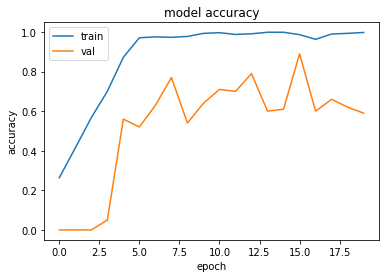

In [ ]:
plot_model_accuracies(history)

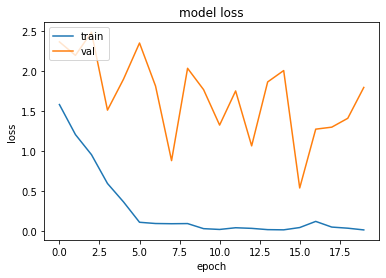

In [ ]:
plot_model_losses(history)



Classification Report

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       199
           1       0.94      1.00      0.97       199
           2       0.98      1.00      0.99       199
           3       0.99      1.00      1.00       199
           4       1.00      0.79      0.89       199

    accuracy                           0.96       995
   macro avg       0.96      0.96      0.96       995
weighted avg       0.96      0.96      0.96       995



Confusion Matrix



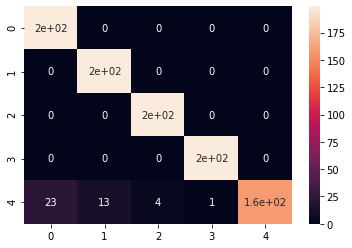

In [ ]:
predictions = model.predict(X)
classification_metrics(Y.argmax(axis=1), predictions.argmax(axis=1))